<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/SDS_DentalCarriesPrediction(Ver_Final%23re).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 건강검진 데이터를 활용한 치아우식증 발생 예측

## - Summary. 최종 작업본 (소스코드)


## #1. 환경 세팅

In [1]:
# ********************* 제출 불필요 *****************************
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

# Deep Learning Model 로드
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

#차원축소 알고리즘 로드
from sklearn.decomposition import PCA

#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

Using TensorFlow backend.


### 1-1. 사용자 정의 함수

In [0]:
# 1. AUC Graph 그리는 함수 선언

def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

# 2. Deep Learning 평가를 위한 평가 함수 정의
from keras import backend as K

def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_negative = K.sum(y_target_yn)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon()) # 'divide by zero error' 예방
    return recall # return a single tensor value

def precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_positive = K.sum(y_pred_yn)
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon()) 
    return precision

def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon()) 
    return _f1score

# 3. TEST SET 결과 출력 사용자 함수
def result_summary(model, x, y):
  pred_y = model.predict(x)
  pred_y = (pred_y>0.5)
  print("Accuracy: {:.4f}".format(accuracy_score(y, pred_y)))
  print("Confusion Matrix: \n", confusion_matrix(y, pred_y))
  print("Classification Report Matrix: \n", classification_report(y, pred_y, digits=3))

  roc_auc = roc_auc_score(y, pred_y)
  print("roc_auc score is : {:.4f}".format(roc_auc))

  fpr, tpr, threshold = roc_curve(y, pred_y)
  roc_auc = auc(fpr, tpr)

  auc_graph(roc_auc, fpr, tpr)

## #2. 파일 Read 및 기초 탐색

In [0]:
set_random_seed = 2580 # Random Seed Setting

In [5]:
set_random_seed = 2580 # seed 지정
target_nm = 'dental_carries' # 타겟 변수 지정

#### 2013년 기준 #########################################################################################################################################
df_raw_2013 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2013_eng.csv', encoding = 'euc-kr')

# 컬럼명 내 불필요한 공백 및 특수문자 제거
df_raw_2013.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 구강검진 결과가 있는 데이터셋만 load
df_data = df_raw_2013[df_raw_2013['examine_mouth']==1]

# 분석과 관련 없는 변수 및 기타 점검이 어려운 치아 관련 변수 삭제 
del_cols = ['baseyear', 'id', 'data_open_date','examine_mouth']
df_data.drop(columns=del_cols, axis=1, inplace=True)

# 치아우식증 결과가 있는 데이터만 끌고 옴
df_data = df_data[~(df_data['dental_carries'].isnull()) & (df_data['dental_carries'] != 2)]

# null 포함 데이터 모두 삭제 
df_data.dropna(how='any', inplace=True)
display(df_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380657 entries, 3 to 999998
Data columns (total 30 columns):
sex                      380657 non-null int64
ageband                  380657 non-null int64
province                 380657 non-null int64
height                   380657 non-null int64
weight                   380657 non-null int64
waist                    380657 non-null int64
sight_l                  380657 non-null float64
sight_r                  380657 non-null float64
hearing_l                380657 non-null float64
hearing_r                380657 non-null float64
bp_systolic              380657 non-null int64
bp_diastolic             380657 non-null int64
bs_before                380657 non-null int64
tot_cholesterol          380657 non-null int64
triglycerides            380657 non-null int64
HDL_cholesterol          380657 non-null int64
LDL_cholesterol          380657 non-null float64
hemoglobin               380657 non-null float64
piu                      380657

None

### #2-1. 데이터결합후 EDA(최종 결과에는 포함 안함 but 어떤 작업을 했다는 언급 시 필요할듯하여 적어놓음)
1. 명목형 데이터의 분포 및 Target 변수와의 연관성
2. 수치형 데이터의 분포
3. 수치형 데이터 log 취한 이후의 분포


- IV 산출 및 외부 변수 결합 이후
4. 결합한 외부 변수들의 target 변수 정보 포함도
5. 최종 모델 입력 전 변수끼리의 상관관계(다중 공선성 제거)

## #3. 데이터샘플링 및 Wrangling

In [6]:
# Data Wrangling을 위해 Dataframe 복사 생성
df_sample = df_data.copy()
print(df_sample[target_nm].value_counts())

# 명목형 변수 변경
category_features = ['sex', 'ageband', 'height', 'weight','province', 'hearing_l', 'hearing_r', 'smoking','drinking', 'piu', 'missing_tooth', 'dental_abrasion', 'wisdom_teeth_abnormal', 'plaque']

for col in df_data.columns:
  if col in category_features:
    df_sample[col] = df_sample[col].astype(object)

0.0    288017
1.0     92640
Name: dental_carries, dtype: int64


### 3-1. 내부 데이터 중 명목형 변수 범주화

In [0]:
# 명목형 변수의 범주화
# 성별코드 변환
df_sample["C_sex"] = df_sample["sex"].apply(lambda x:  'Male' if x == 1 else 'Female')

# 연령대코드 5세 단위 변환
min_age_code = df_sample["ageband"].min()

df_sample["C_ageband"] = df_sample["ageband"].apply(lambda x:  (x-1)*5 + 20 if min_age_code == 1 else (x-1)*5).astype(object)

# 시도코드 변환
df_sample["C_province"] = np.where(df_sample['province'] == 11, 'Seoul', 
                            np.where(df_sample['province']== 26, 'Busan', 
                              np.where(df_sample['province'] == 27, 'Daegu', 
                                np.where(df_sample['province'] == 28, 'Incheon', 
                                  np.where(df_sample['province'] == 29, 'Kwangju', 
                                    np.where(df_sample['province'] == 30, 'Daejeon', 
                                      np.where(df_sample['province'] == 31, 'Ulsan', 
                                        np.where(df_sample['province'] == 36, 'Sejong', 
                                          np.where(df_sample['province'] == 41, 'Gyeonggi', 
                                            np.where(df_sample['province'] == 42, 'Gangwon', 
                                              np.where(df_sample['province'] == 43, 'Chungbuk', 
                                                np.where(df_sample['province'] == 44, 'Chungnam', 
                                                  np.where(df_sample['province'] == 45, 'Jeonbuk', 
                                                    np.where(df_sample['province'] == 46, 'Jeonnam', 
                                                      np.where(df_sample['province'] == 47, 'Gyungbuk', 
                                                        np.where(df_sample['province'] == 48, 'Gyungnam', 
                                                          np.where(df_sample['province'] == 49, 'Jeju', 'Err')
                                      ))))))))))))))))

# 청력좌  변환
df_sample["C_hearing_l"] = df_sample["hearing_l"].apply(lambda x:  'Normal' if x == 1 else 'Abnormal')

# 청력우  변환
df_sample["C_hearing_r"] = df_sample["hearing_r"].apply(lambda x:  'Normal' if x == 1 else 'Abnormal')

# 요단백  변환
df_sample["C_piu"] = df_sample["piu"].apply(lambda x:  'Negative' if x == 1 else 'Positive')

# 흡연상태  변환
df_sample["C_smoking"] = df_sample["smoking"].apply(lambda x:  'NonSmoking' if x == 1 else ('StopSmoking' if x==2 else 'Smoking'))

# 음주여부  변환
df_sample["C_drinking"] = df_sample["drinking"].apply(lambda x:  'NonDrinking' if x == 0 else 'Drinking')

# 결손치 여부  변환
df_sample["C_missing_tooth"] = df_sample["missing_tooth"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 치석 여부  변환
df_sample["C_dental_abrasion"] = df_sample["dental_abrasion"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 치석 여부  변환
df_sample["C_wisdom_teeth_abnormal"] = df_sample["wisdom_teeth_abnormal"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 치석 여부  변환
df_sample["C_plaque"] = df_sample["plaque"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 변환 명목형 원 컬럼 삭제
del_obj_trans_cols = ['sex', 'ageband', 'province', 'hearing_l', 'hearing_r', 'piu', 'smoking', 'drinking', 'missing_tooth', 'dental_abrasion', 'wisdom_teeth_abnormal', 'plaque']
df_sample.drop(columns=del_obj_trans_cols, axis=1, inplace=True)

In [0]:
# # 내부 수치형 변수 구간화(작업 진행하였으나 실제 모델 성능에 좋은 Effect가 없어 삭제)
# # BMI 변수 추가
# df_sample["N_BMI"] = (df_sample["weight"]/(df_sample["height"]*df_sample["height"])).astype(float)

# # 공복 혈당 
# # 100 이하는 정상/ 100 ~ 125는 '공복혈당장애 - 당뇨 전단계'/ 125 이상은 당뇨
# # 당뇨병의 중간인 100~125 mg/dL가 나오거나 

# df_sample["N_diabetes"] = np.where(df_sample['bs_before'].between(0, 100, inclusive=True), 'Normal', 
#                                np.where(df_sample['bs_before'].between(100, 124.9, inclusive=True), 'Prediabetes', 
#                                         'Diabetes')
#                               )

# # HDL 콜레스테롤
# # HDL 콜레스테롤 수치가 남자에서 40 mg/dL (1.0 mmol/L) 이하 또는 여자에서 50 mg/dL (1.3 mmol/L) 이하일 경우에는 다른 위험인자와 독립적으로 심장 질환의 위험도가 증가
# # HDL 콜레스테롤 수치가 남자에서 40-50 mg/dL (1.0-1.3 mmol/L) 그리고 여자에서 50-59 mg/dL (1.3-1.5 mmol/L)인 경우에는 심장 질환의 평균위험도와 연관
# # 보통 HDL 콜레스테롤 수치가 60 mg/dL (1.55 mmol/L) 또는 그 이상일 경우에는 심장 질환 평균 위험도보다 낮음
# # National Cholesterol Education Panel Adult Treatment Guidelines에 따르면 HDL 콜레스테롤 수치가 60 mg/dL 이상일 경우 심장 질환에서 보호되고 음성 위험 인자로서 치료되어야 함
# df_sample["N_HDL"] = np.where(
#                     (df_sample['C_sex'] == "Female") & (df_sample['HDL_cholesterol']<= 50), 'HighRisk', 
#                        np.where(
#                          (df_sample['C_sex']== "Female") & (df_sample['HDL_cholesterol'].between(50, 59.9, inclusive=True)), 'MediumRisk', 
#                            np.where(
#                                (df_sample['C_sex']== "Male") & (df_sample['HDL_cholesterol']<= 40), 'HighRisk', 
#                                       np.where(
#                                           (df_sample['C_sex']== "Male") & (df_sample['HDL_cholesterol'].between(40, 49.9, inclusive=True)), 'MediumRisk', 'Normal')
#                           )))
# # LDL 콜레스테롤(혈중 모든 콜레스테롤 중 LDL 콜레스테롤이 심장질환에 대한 위험도를 확인하는데 가장 중요한 지표)
# # 대부분의 치료 결정이 LDL 수치를 토대로 이루어지기 때문에 이 검사를 통해 식이요법 또는 운동처방의 효과를 감시하거나 지질감소 약물을 처방하는 것이 유용한지에 대한 평가
# # 100 mg/dL (2.59mmol/L) 미만 – 최적
# # 100-129 mg/dL (2.59-3.34 mmol/L) – 최적에 인접
# # 130-159 mg/dL (3.37-4.12 mmol/L) – 상한 경계성
# # 160-189 mg/dL (4.15-4.90 mmol/L) – 높음
# # 190 mg/dL (4.90 mmol) 이상 – 매우 높음
# df_sample["N_LDL"] = np.where(df_sample['LDL_cholesterol']<100, 'Good', 
#                     np.where(df_sample['LDL_cholesterol'].between(100, 122.9, inclusive=True), 'NearGood', 
#                              np.where(df_sample['LDL_cholesterol'].between(130, 159.9, inclusive=True), 'Upperbound', 
#                                       np.where(df_sample['LDL_cholesterol'].between(160, 189.9, inclusive=True), 'High', 'VeryHigh')
#                               )))

# # 트리글리세라이드
# # 지방의 한 형태로서 몸의 주요 에너지원, 트리글리세라이드가 증가하는 것은, 이유가 분명하지 않으나 심혈관 질환으로 진행될 위험의 증가와 관련
# # 일부 인자들 즉, 운동 부족, 과체중, 흡연, 과음 및 당뇨와 신질환 등의 질병 상태가 고트리글리세라이드혈증 및 심혈관 질환 위험도 증가에 기여할 수 있음
# # 성인에서는 트리글리세라이드 결과가 아래와 같이 나뉘어진다.
# # 150 mg/dL (1.7 mmol/L) 미만: 바람직
# # 150-199 mg/dL (1.7-2.2 mmol/L): 경계성증가
# # 200-499 mg/dL (2.3-5.6 mmol/L): 증가: 
# # 500 mg/dL (5.6 mmol/L) 이상: 매우 증가
# # 이 수치는 공복시 트리글리세라이드 수치에 기준합니다.
# df_sample["N_TRI"] = np.where(df_sample['triglycerides']<150, 'Good', 
#                     np.where(df_sample['triglycerides'].between(150, 199.9, inclusive=True), 'Check', 
#                              np.where(df_sample['triglycerides'].between(200, 499.9, inclusive=True), 'Increased', 'VeryIncreased')
#                               ))

# # 혈색소
# # 성인의 데시리터(100밀리리터) 당 12그램에서 18그램 정도: 정상치
# # 18그램 이상: 폐질환 등 기타 이상
# # 12그램 미만: 빈혈
# df_sample["N_HEMO"] = np.where(df_sample['hemoglobin'].between(12, 17.9, inclusive=True), 'Normal', 
#                     np.where(df_sample['hemoglobin']>=18, 'Abnormal', 'Anemia'))

# # 요단백: 소변으로 빠져나가는 잉여의 단백질을 검출하기 위해, 신장 기증을 평가하고 모니터하는 것을 돕기 위해,  그리고 신장 손상을 검출하기 위해 검사
# # 요단백은 보통 소변에서 검출 되지 않음

# # 혈중 크레아티닌 농도의 
# # 정상범위는 0.50~1.4 mg/dL 입니다
# # 근육량에 비례하는 검사결과이므로 여성보다는 남성에게서 약간 높은 수치가 나타나고, 식사나 운동이 결과에 영향이 거의 미치지 않습니다. 지속적으로 많은 양의 육식을 섭취한 경우에는 크레아티닌 농도가 높게 측정됩니다.
# df_sample["N_CRE"] = np.where(df_sample['serum_creatinine'].between(0.5, 1.4, inclusive=True), 'Normal', 'Abnormal')

# # 혈청지오티AST:
# #  간기능을 평가하는 기초검사항목으로서 알코올성 간장애나 만성 간질환에서 주로 증가한다.
 

# # 혈청지오티ALT:
# # 간기능을 평가하는 기초검사항목으로서 급성 간염 시 주로 증가한다.
# # 증가: 간질환, 심근경색, 지방간, 비만


# # 감마지티피
# # 간장세포나 담낭세포가 파괴되면 감마지티피가 혈액속으로 누출되어 수치가 높아짐
# # 남자는 50IU 이하, 여자는 32IU이하가 정상
# # 100이하면 음주 조절을 통해 조정 가능하나 100 이상이면 지방간이 진행되고 있을 가능성이 높음
# # 200 이상이면 담석이나 담도암등으로 담도가 막혀있을 가능성이 높음
# # 500 이상이면 황달
# df_sample["N_GTP"] = np.where((df_sample['GammaGTP'] >= 500), 'Jaundice', 
#                        np.where(df_sample['GammaGTP']>=200, 'Abnormal', 
#                            np.where(df_sample['GammaGTP']>= 100, 'PossibleAbnormal', 
#                              np.where((df_sample['C_sex']== "Male") & (df_sample['GammaGTP']<=50), 'Normal',
#                               np.where((df_sample['C_sex']== "Female") & (df_sample['GammaGTP']<=32), 'Normal', 'Check')
#                           ))))

# # 변환 수치형 원 컬럼 삭제
# del_num_trans_cols = ['bs_before', 'HDL_cholesterol', 'LDL_cholesterol', 'triglycerides', 'hemoglobin', 'serum_creatinine', 'GammaGTP']
# df_sample.drop(columns=del_num_trans_cols, axis=1, inplace=True)

### 3-2. 내부 데이터 중 수치형 변수 Log화 (EDA 결과 좌측으로 분포가 쏠린 데이터 대상)

In [0]:
# 수치형 변수들 중 분포 이슈로 log 값을 취할 필요 있는 변수들 추출
num_ln_target_features = ['sight_l', 'sight_r', 'AST','ALT', 'bs_before','serum_creatinine','GammaGTP','tot_cholesterol', 'triglycerides']

# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_ln_cols = list(map(lambda x: "LN_"+str(x), num_ln_target_features))

num_pipeline = Pipeline([
        ('log_scaler', FunctionTransformer(np.log1p, validate=True)), # pipeline 내 log transformation을 위해 Function Transfomer 사용
        ('normalizer', MinMaxScaler()),
    ])

piped_np = num_pipeline.fit_transform(df_sample[num_ln_target_features])
piped_df = pd.DataFrame(piped_np, columns=num_ln_cols)

piped_df.head()

df_sample.drop(columns=num_ln_target_features, axis=1, inplace=True)

In [10]:
# 기존 Dataframe과 Log 취한 변수들의 Dataframe을 합쳐줌
print("Before Re-indexing: Data count is ", len(df_sample))
df_sample.drop_duplicates()
df_sample.reset_index(inplace=True, drop=True)
print("After Re-indexing: Data count is ", len(df_sample))

df_fe = pd.concat([df_sample, piped_df], axis=1)
df_fe.head()

Before Re-indexing: Data count is  380657
After Re-indexing: Data count is  380657


,height,weight,waist,bp_systolic,bp_diastolic,HDL_cholesterol,LDL_cholesterol,hemoglobin,dental_carries,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,C_missing_tooth,C_dental_abrasion,C_wisdom_teeth_abnormal,C_plaque,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,LN_bs_before,LN_serum_creatinine,LN_GammaGTP,LN_tot_cholesterol,LN_triglycerides
0,145,40,62,110,70,87,110.0,12.4,1.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.260671,0.260671,0.324587,0.242257,0.273586,0.097408,0.393001,0.562271,0.524264
1,145,45,72,100,53,46,140.0,13.1,1.0,Female,20,Seoul,Normal,Normal,Negative,NonSmoking,Drinking,Normal,Normal,Normal,Abnormal,0.214731,0.037939,0.313473,0.301486,0.300466,0.110197,0.313119,0.560370,0.632675
2,145,60,81,119,79,55,1494.0,12.7,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.105152,0.214731,0.430787,0.469957,0.389152,0.083842,0.412729,0.578979,0.544586
3,150,40,61,132,88,83,33.0,13.7,0.0,Female,20,Gyungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Abnormal,0.214731,0.214731,0.353958,0.301486,0.328540,0.122296,0.258977,0.364558,0.511384
4,150,40,61,95,65,56,83.0,12.4,0.0,Female,20,Gyeonggi,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Abnormal,0.135235,0.135235,0.344750,0.362609,0.289235,0.083842,0.258977,0.438554,0.539037


## #4. 외부 데이터 결합

In [0]:
df_add1 = pd.read_csv('../gdrive/My Drive/sds/data/DentalExamineResult_2014_PortionbyTotInspector.csv', encoding = 'euc-kr')
df_add2 = pd.read_csv('../gdrive/My Drive/sds/data/KOSIS_AgeSex_AverageDentalVisitCnt_2012.csv', encoding = 'euc-kr')
df_add3 = pd.read_csv('../gdrive/My Drive/sds/data/KOSIS_DentalPrevalenceTrend_2012.csv', encoding = 'euc-kr')
df_add4 = pd.read_csv('../gdrive/My Drive/sds/data/chs_12_final_from_python.csv', encoding = 'euc-kr')

# Multiple Key를 사용하여 Join
# left_on=['column_name1','column_name2'], right_on = ['column_name3','column_name4']

df_new = pd.merge(left=df_fe, right=df_add1, how='outer', left_on=['C_province','C_sex'], right_on = ['Province','Sex'], sort=False)
df_new.drop(columns=['Province','Sex'], axis=1, inplace=True)

df_new = pd.merge(left=df_new, right=df_add2, how='outer', left_on=['C_ageband','C_sex'], right_on = ['Ageband','Sex'], sort=False)
df_new.drop(columns=['Ageband','Sex'], axis=1, inplace=True)

df_new = pd.merge(left=df_new, right=df_add3, how='outer', left_on=['C_ageband','C_sex'], right_on = ['Ageband','Sex'], sort=False)
df_new.drop(columns=['Ageband','Sex'], axis=1, inplace=True)

df_new = pd.merge(left=df_new, right=df_add4, how='left', left_on=['C_ageband','C_sex','C_province', 'weight', 'height'], right_on = ['R_ageband','R_sex','R_province','R_weight','R_height'], sort=False)
df_new.drop(columns=['R_ageband','R_sex','R_province','R_weight','R_height'], axis=1, inplace=True)

# 외부변수와 매칭이 되지 않는 항목은 버림
df_new.dropna(how='any', inplace=True)

## #5. 모델 입력 데이터 Transform

In [0]:
# 치아우식 0과 1의 값을 5만건씩 총 10만건 추출
df_new = df_new.groupby(target_nm).apply(lambda x: x.sample(n=50000, random_state=set_random_seed))
df_new.reset_index(drop=True, inplace=True)

In [0]:
# # 변수 Selection을 위한 Information Value 값 산출(대부분의 변수가 Weak Predictor 보다 낮은 연결성을 갖고 있고 모델별로 Positive, Negative 효과가 섞여서 삭제)
# # woe package install
# ! pip install woe

# # Define a binning function for continous independent variables
# max_bin = 20
# force_bin = 3

# def mono_bin(Y, X, n = max_bin):
#   df1 = pd.DataFrame({"X": X, "Y": Y})
#   justmiss = df1[['X','Y']][df1.X.isnull()]
#   notmiss = df1[['X','Y']][df1.X.notnull()]
#   r = 0
#   while np.abs(r) < 1:
#     try:
#       global d1
#       global d2
#       d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
#       d2 = d1.groupby('Bucket', as_index=True)
#       r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
#       n = n - 1 
#     except Exception as e:
#       n = n - 1
#       break
      
#   if len(d2) == 1:
#     n = force_bin         
#     bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
#     if len(np.unique(bins)) == 2:
#         bins = np.insert(bins, 0, 1)
#         bins[1] = bins[1]-(bins[1]/2)
#     d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
#     d2 = d1.groupby('Bucket', as_index=True)

#   d3 = pd.DataFrame({},index=[])
#   d3["MIN_VALUE"] = d2.min().X
#   d3["MAX_VALUE"] = d2.max().X
#   d3["COUNT"] = d2.count().Y
#   d3["EVENT"] = d2.sum().Y
#   d3["NONEVENT"] = d2.count().Y - d2.sum().Y
#   d3=d3.reset_index(drop=True)

#   if len(justmiss.index) > 0:
#       d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
#       d4["MAX_VALUE"] = np.nan
#       d4["COUNT"] = justmiss.count().Y
#       d4["EVENT"] = justmiss.sum().Y
#       d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
#       d3 = d3.append(d4,ignore_index=True)

#   d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
#   d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
#   d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
#   d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
#   d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
#   d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
#   d3["VAR_NAME"] = "VAR"
#   d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
#   d3 = d3.replace([np.inf, -np.inf], 0)
#   d3.IV = d3.IV.sum()

#   return(d3)
  
# # Define a binning function for categorical independent variables
# def char_bin(Y, X):
#   df1 = pd.DataFrame({"X": X, "Y": Y})
#   justmiss = df1[['X','Y']][df1.X.isnull()]
#   notmiss = df1[['X','Y']][df1.X.notnull()]    
#   df2 = notmiss.groupby('X',as_index=True)

#   d3 = pd.DataFrame({},index=[])
#   d3["COUNT"] = df2.count().Y
#   d3["MIN_VALUE"] = df2.sum().Y.index
#   d3["MAX_VALUE"] = d3["MIN_VALUE"]
#   d3["EVENT"] = df2.sum().Y
#   d3["NONEVENT"] = df2.count().Y - df2.sum().Y

#   if len(justmiss.index) > 0:
#     d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
#     d4["MAX_VALUE"] = np.nan
#     d4["COUNT"] = justmiss.count().Y
#     d4["EVENT"] = justmiss.sum().Y
#     d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
#     d3 = d3.append(d4,ignore_index=True)

#   d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
#   d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
#   d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
#   d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
#   d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
#   d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
#   d3["VAR_NAME"] = "VAR"
#   d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
#   d3 = d3.replace([np.inf, -np.inf], 0)
#   d3.IV = d3.IV.sum()
#   d3 = d3.reset_index(drop=True)

#   return(d3)

# # Calculate Information Values
# def calc_iv_all(df1, target):
    
#   stack = traceback.extract_stack()
#   filename, lineno, function_name, code = stack[-2]
#   vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
#   final = (re.findall(r"[\w']+", vars_name))[-1]

#   x = df1.dtypes.index
#   count = -1

#   for i in tqdm_notebook(x):
#     if i.upper() not in (final.upper()):
#       if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
#         conv = mono_bin(target, df1[i])
#         conv["VAR_NAME"] = i
#         count = count + 1
#       else:
#         conv = char_bin(target, df1[i])
#         conv["VAR_NAME"] = i            
#         count = count + 1

#       if count == 0:
#         iv_df = conv
#       else:
#         iv_df = iv_df.append(conv,ignore_index=True)

#   iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
#   iv = iv.reset_index()
#   return(iv_df,iv)

# # IV 산출
# iv_df, IV_first = calc_iv_all(df_new,df_new[target_nm])

# # IV 값 내림차순 정렬
# IV_first.sort_values('IV',ascending=False)

# IV_select_col = list(IV_first[IV_first['IV']>=0.015]['VAR_NAME'])

# # 독립변수와 종속변수를 나눠 줌
# # data_x = df_new[df_new.columns.difference([target_nm])]
# data_x = df_new[IV_select_col]
# data_y = df_new[target_nm].astype('float64')

# # 데이터를 나눈 뒤 속성별로 컬럼을 분류
# num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
# cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

# num_attribs = list(set(num_attribs) - set([target_nm]))

In [0]:
# 독립변수와 종속변수를 나눠 줌
data_x = df_new[df_new.columns.difference([target_nm])]
data_y = df_new[target_nm].astype('float64')

# 데이터를 나눈 뒤 속성별로 컬럼을 분류
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set([target_nm]))

In [0]:
# 명목형 변수들 LabelEncoding 실행
# label = LabelEncoder()
# for col in data_x[cat_attribs].columns:   
#   data_x[col] = label.fit_transform(data_x[col])
#   data_x = pd.get_dummies(data_x, columns =[col], prefix=col+"_lb")

# 데이터를 나눈 뒤 속성별로 컬럼을 분류
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set([target_nm]))

# 수치형 변수 정규화 
num_pipeline = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
    ])

# numpy 형식으로 전체 변경
full_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_attribs),
        ("cat_encoder", OneHotEncoder(sparse=False), cat_attribs),
    ])

data_x_piped = full_pipeline.fit_transform(data_x)
data_y_piped = data_y.values

In [0]:
# 최종 Train & Test Set 분리
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x_piped, data_y_piped, test_size = 0.2, random_state = set_random_seed)

In [17]:
train_x.shape

(80000, 152)

### #6. 모델 준비 및 결과 출력

### 6-1. Deep Learning Model

In [0]:
# wrap the model using the function you created
def create_model(modelnm='none', optimizer='sgd', activation = 'tanh', kernel_initializer='glorot_uniform', dropout=0.3, epochs=20, batch_size=128):
    input_dim = train_x.shape[1]
    model = Sequential()
    # 첫 번째 Layer (Input layer)
    model.add(Dense(input_dim=input_dim, kernel_initializer=kernel_initializer, output_dim=256))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout)) # 30% 정도를 Drop 

    # # 두 번째 Layer (Hidden layer 1)
    model.add(Dense(output_dim=256, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout)) # 30% 정도를 Drop 

    # # 세 번째 Layer (Hidden layer 2)
    model.add(Dense(output_dim=256, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout)) # 30% 정도를 Drop 

    # Dense Layer (Output layer)
    model.add(Dense(output_dim=1))
    model.add(Activation("sigmoid"))

    model.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['accuracy', precision, recall, f1score])

    return model





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 64000 samples, validate on 16000 samples
Epoch 1/100





64000/64000 [==============================] - 11s 171us/step - loss: 0.6961 - acc: 0.5881 - precision: 0.5906 - recall: 0.5860 - f1score: 0.5865 - val_loss: 0.6412 - val_acc: 0.6385 - val_precision: 0.6438 - val_recall: 0.6212 - val_f1score: 0.6303
Epoch 2/100
64000/64000 [==============================] - 6s 91us/step - loss: 0.6640 - acc: 0.6084 - precision: 0.6103 - recall: 0.6089 - f1score: 0.6079 - val_loss: 0.6388 - val_acc: 0.6406 - val_precision: 0.6431 - val_recall: 0.6334 - val_f1score: 0.6363
Epoch 3/100
64000/64000 [==============================] - 6s 92us/step - loss: 0.6539 - acc: 0.6192 - precision: 0.6214 - recall: 0.6173 - f1score: 0.6175 - val_loss: 0.6386 - val_acc: 0.6421 - val_precis

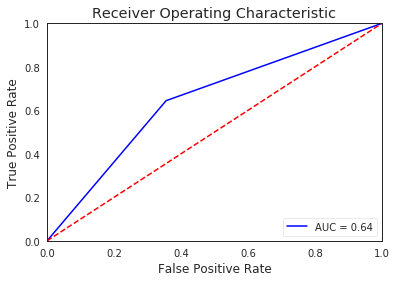

In [19]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20),
              keras.callbacks.ModelCheckpoint(filepath='keras_classifier_1.h5',
                                              monitor='val_loss',
                                              save_best_only=True)]

keras_clf1 = KerasClassifier(modelnm = 'kc1', build_fn = create_model, optimizer= 'sgd', activation = 'tanh', epochs=100, batch_size=128)
keras_clf1.fit(train_x, train_y, validation_split=0.2, callbacks=callbacks)
result_summary(keras_clf1, test_x, test_y)

Accuracy: 0.6445
Confusion Matrix: 
 [[6506 3574]
 [3536 6384]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.648     0.645     0.647     10080
         1.0      0.641     0.644     0.642      9920

    accuracy                          0.644     20000
   macro avg      0.644     0.644     0.644     20000
weighted avg      0.645     0.644     0.645     20000

roc_auc score is : 0.6445


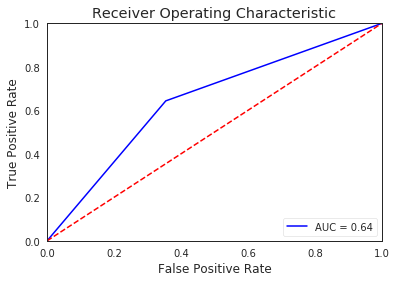

In [20]:
kc1_best = keras.models.load_model('keras_classifier_1.h5', custom_objects={'precision': precision, 'recall':recall, 'f1score':f1score})
result_summary(kc1_best, test_x, test_y)

Train on 64000 samples, validate on 16000 samples
Epoch 1/100
64000/64000 [==============================] - 7s 106us/step - loss: 0.7004 - acc: 0.5878 - precision: 0.5899 - recall: 0.5873 - f1score: 0.5869 - val_loss: 0.6436 - val_acc: 0.6381 - val_precision: 0.6431 - val_recall: 0.6209 - val_f1score: 0.6299
Epoch 2/100
64000/64000 [==============================] - 6s 91us/step - loss: 0.6659 - acc: 0.6112 - precision: 0.6132 - recall: 0.6098 - f1score: 0.6099 - val_loss: 0.6398 - val_acc: 0.6408 - val_precision: 0.6421 - val_recall: 0.6375 - val_f1score: 0.6377
Epoch 3/100
64000/64000 [==============================] - 6s 93us/step - loss: 0.6550 - acc: 0.6183 - precision: 0.6205 - recall: 0.6179 - f1score: 0.6175 - val_loss: 0.6387 - val_acc: 0.6421 - val_precision: 0.6471 - val_recall: 0.6258 - val_f1score: 0.6343
Epoch 4/100
64000/64000 [==============================] - 6s 91us/step - loss: 0.6490 - acc: 0.6234 - precision: 0.6259 - recall: 0.6201 - f1score: 0.6213 - val_loss: 0

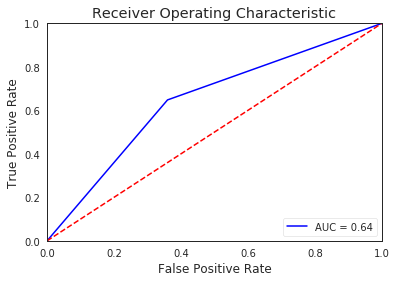

In [21]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath='keras_classifier_2.h5',
                                              monitor='val_loss',
                                              save_best_only=True)]

keras_clf2 = KerasClassifier(modelnm = 'kc2', build_fn = create_model, optimizer= 'sgd', activation = 'tanh', epochs=100, batch_size=128)
keras_clf2.fit(train_x, train_y, validation_split=0.2, callbacks=callbacks)
result_summary(keras_clf2, test_x, test_y)

Accuracy: 0.6430
Confusion Matrix: 
 [[6406 3674]
 [3467 6453]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.649     0.636     0.642     10080
         1.0      0.637     0.651     0.644      9920

    accuracy                          0.643     20000
   macro avg      0.643     0.643     0.643     20000
weighted avg      0.643     0.643     0.643     20000

roc_auc score is : 0.6430


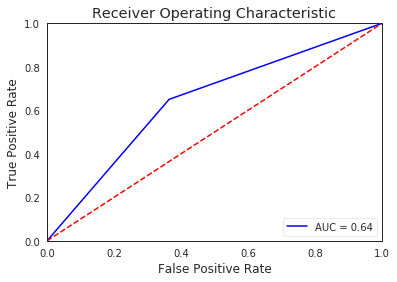

In [22]:
kc2_best = keras.models.load_model('keras_classifier_2.h5', custom_objects={'precision': precision, 'recall':recall, 'f1score':f1score})
result_summary(kc2_best, test_x, test_y)

Train on 64000 samples, validate on 16000 samples
Epoch 1/100
64000/64000 [==============================] - 7s 115us/step - loss: 0.7061 - acc: 0.5872 - precision: 0.5880 - recall: 0.6000 - f1score: 0.5916 - val_loss: 0.6391 - val_acc: 0.6343 - val_precision: 0.6479 - val_recall: 0.5884 - val_f1score: 0.6148
Epoch 2/100
64000/64000 [==============================] - 6s 97us/step - loss: 0.6633 - acc: 0.6103 - precision: 0.6131 - recall: 0.6073 - f1score: 0.6083 - val_loss: 0.6382 - val_acc: 0.6366 - val_precision: 0.6546 - val_recall: 0.5792 - val_f1score: 0.6126
Epoch 3/100
64000/64000 [==============================] - 6s 95us/step - loss: 0.6534 - acc: 0.6185 - precision: 0.6224 - recall: 0.6105 - f1score: 0.6146 - val_loss: 0.6369 - val_acc: 0.6397 - val_precision: 0.6565 - val_recall: 0.5878 - val_f1score: 0.6182
Epoch 4/100
64000/64000 [==============================] - 6s 95us/step - loss: 0.6464 - acc: 0.6240 - precision: 0.6292 - recall: 0.6117 - f1score: 0.6185 - val_loss: 0

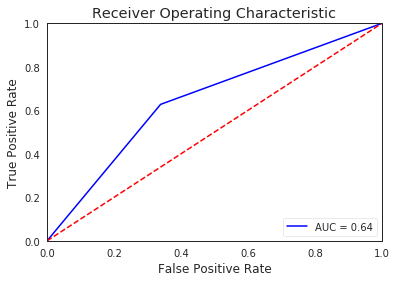

In [23]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20),
              keras.callbacks.ModelCheckpoint(filepath='keras_classifier_3.h5',
                                              monitor='val_loss',
                                              save_best_only=True)]

keras_clf3 = KerasClassifier(modelnm = 'kc3', build_fn = create_model, optimizer= 'sgd', activation = 'elu' , epochs=100, batch_size=128)
keras_clf3.fit(train_x, train_y, validation_split=0.2, callbacks=callbacks)
result_summary(keras_clf3, test_x, test_y)

Accuracy: 0.6452
Confusion Matrix: 
 [[6708 3372]
 [3723 6197]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.643     0.665     0.654     10080
         1.0      0.648     0.625     0.636      9920

    accuracy                          0.645     20000
   macro avg      0.645     0.645     0.645     20000
weighted avg      0.645     0.645     0.645     20000

roc_auc score is : 0.6451


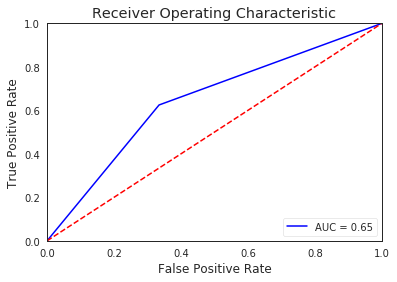

In [24]:
kc3_best = keras.models.load_model('keras_classifier_3.h5', custom_objects={'precision': precision, 'recall':recall, 'f1score':f1score})
result_summary(kc3_best, test_x, test_y)

### 6-2. Machine Learning Model

#### 6-2-1. 가용자원 내 가능 모델 우선 테스트

In [0]:
#Machine Learning Algorithm (MLA) 선택 및 초기화
MLA = [ 
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
   
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #xgboost
    XGBClassifier()
    ]

In [0]:
# 모델평가를 위한 변수 세팅
score_pram = ['accuracy', 'precision','recall','f1']

#Create Table to Compare Canonical Models
MLA_Result_columns = ['ModelName','Dataset','Accuracy','Precision','Recall','F1']
MLA_compare = pd.DataFrame(columns = MLA_Result_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame(train_y)

In [0]:
# index through MLA and save performance to table
row_index = 0
cv = 5
# 알고리즘을 하나씩 꺼내면서 loop
for alg in tqdm_notebook(MLA):
    print(alg, "algorithm modeling starts ... ")
    #알고리즘의 이름은 할당하고, [row_index, MLA Name]에 이름을 넣고, [row_index, MLA Parameters]에 알고리즘의 파라미터들을 할당
    Model_Name = alg.__class__.__name__
    
    cv_results = cross_validate(alg, train_x, train_y, cv=cv, scoring=score_pram, return_train_score=True, n_jobs=-1, verbose=1)
    
    train_cnt = 0
    test_cnt = 0
    
    for i in cv_results.keys():
      if("train" in i and train_cnt == 0):
        MLA_compare.loc[row_index, 'ModelName'] = Model_Name
        MLA_compare.loc[row_index, 'Dataset'] = "TrainSet"
        MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['train_accuracy'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Precision'] = format(cv_results['train_precision'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Recall'] = format(cv_results['train_recall'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'F1'] = format(cv_results['train_f1'].mean(), "10.4f")
        row_index+=1
        train_cnt+=1
      elif("test" in i and test_cnt ==0):
        MLA_compare.loc[row_index, 'ModelName'] = Model_Name
        MLA_compare.loc[row_index, 'Dataset'] = "ValidSet"
        MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['test_accuracy'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Precision'] = format(cv_results['test_precision'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Recall'] = format(cv_results['test_recall'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'F1'] = format(cv_results['test_f1'].mean(), "10.4f")
        row_index+=1
        test_cnt+=1

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None, cv=None,
                  fit_intercept=True, normalize=False, scoring=None,
                  store_cv_values=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GaussianNB(priors=None, var_smoothing=1e-09) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best') algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, random_state=None,
                    splitter='random') algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [0]:
MLA_compare.sort_values(by = ['Dataset','Accuracy'], ascending = False, inplace = True)
MLA_compare['Accuracy'] = MLA_compare['Accuracy'].astype(float)
display(MLA_compare)

#### 6-2-2. 자원 내 가능 어려운 모델은 차원 축소 후 테스트

전체 모델 테스트에 대한 차원 축소는 테스트 결과 효율이 나빠져 차원축소 진행하지 않음

In [0]:
# MLA = [ 
#     #SVM
#     svm.SVC(probability=True),
#     svm.NuSVC(probability=True),
#     svm.LinearSVC(),  
    
#     #Nearest Neighbor
#     neighbors.KNeighborsClassifier(),

#     #Gaussian Processes
#     # gaussian_process.GaussianProcessClassifier()
#     ]

In [0]:
# pca = PCA(.90)

# train_pca_x = pca.fit_transform(train_x)
# test_pca_x = pca.fit_transform(test_x)

In [0]:
# # index through MLA and save performance to table
# cv = 5
# # 알고리즘을 하나씩 꺼내면서 loop
# for alg in tqdm_notebook(MLA):
#     print(alg, "algorithm modeling starts ... ")
#     #알고리즘의 이름은 할당하고, [row_index, MLA Name]에 이름을 넣고, [row_index, MLA Parameters]에 알고리즘의 파라미터들을 할당
#     Model_Name = alg.__class__.__name__
    
#     cv_results = cross_validate(alg, train_pca_x, train_y, cv=cv, scoring=score_pram, return_train_score=True, n_jobs=-1, verbose=1)
    
#     train_cnt = 0
#     test_cnt = 0
    
#     for i in cv_results.keys():
#       if("train" in i and train_cnt == 0):
#         MLA_compare.loc[row_index, 'ModelName'] = Model_Name
#         MLA_compare.loc[row_index, 'Dataset'] = "TrainSet"
#         MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['train_accuracy'].mean(), "10.4f")
#         MLA_compare.loc[row_index, 'Precision'] = format(cv_results['train_precision'].mean(), "10.4f")
#         MLA_compare.loc[row_index, 'Recall'] = format(cv_results['train_recall'].mean(), "10.4f")
#         MLA_compare.loc[row_index, 'F1'] = format(cv_results['train_f1'].mean(), "10.4f")
#         row_index+=1
#         train_cnt+=1
#       elif("test" in i and test_cnt ==0):
#         MLA_compare.loc[row_index, 'ModelName'] = Model_Name
#         MLA_compare.loc[row_index, 'Dataset'] = "ValidSet"
#         MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['test_accuracy'].mean(), "10.4f")
#         MLA_compare.loc[row_index, 'Precision'] = format(cv_results['test_precision'].mean(), "10.4f")
#         MLA_compare.loc[row_index, 'Recall'] = format(cv_results['test_recall'].mean(), "10.4f")
#         MLA_compare.loc[row_index, 'F1'] = format(cv_results['test_f1'].mean(), "10.4f")
#         row_index+=1
#         test_cnt+=1

In [0]:
# MLA_compare.sort_values(by = ['Dataset','Accuracy'], ascending = False, inplace = True)
# MLA_compare['Accuracy'] = MLA_compare['Accuracy'].astype(float)
# display(MLA_compare)

In [0]:
# #barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
# plt.figure(figsize=(8,6))
# sns.barplot(x='Accuracy', y = 'ModelName', data = MLA_compare[MLA_compare['Dataset']== 'ValidSet'], palette=sns.husl_palette(n_colors=20,l=.7))

# #prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
# plt.title('Machine Learning Algorithm Accuracy Score \n')
# plt.xlabel('Accuracy Score (%)')
# plt.ylabel('Algorithm')
# plt.show()

## #7.Model Selection

In [0]:
# top_models = MLA_compare[:4]['ModelName'].values # 상위 4개 모델 Tuninig
# top_models

## #8. Hyper Parameter Tuning
: GridSearch, RandomizedSearch, BaysianOptimization에 대한 이론적 배경 서술(Baysian은 적용안할 예정이라 굳이 안써도 무관할 듯)

### #8-1. GridSearchCV

In [0]:
cv = 5

#### 8-1-1. Logistic Regression

In [0]:
lr_clf = linear_model.LogisticRegression()
lr_clf.fit(train_x, train_y)
print(lr_clf)

# GridSearch 이전 기본 모델 출력
result_summary(lr_clf, test_x, test_y)

# GridSearch 시행

param_grid = {}
param_grid["C"] =  [0.001, 0.01, 0.1, 10]
param_grid["penalty"] =  ['l1','l2']
param_grid["max_iter"] = [100,150]

grid_lr_clf = GridSearchCV(lr_clf, param_grid, n_jobs=-1, cv=cv, verbose=1) 
grid_lr_clf.fit(train_x, train_y)
print(grid_lr_clf.best_estimator_)

# GridSearch 이후 결과 출력
result_summary(grid_lr_clf.best_estimator_, test_x, test_y) 

#### 8-1-2. LinearDiscriminantAnalysis
선형판별분석:데이터를 특정 한 축에 사영(projection)한 후에 두 범주를 잘 구분할 수 있는 직선을 찾는 걸 목표

In [0]:
lda_clf = discriminant_analysis.LinearDiscriminantAnalysis()
lda_clf.fit(train_x,train_y)
print(lda_clf)

# GridSearch 이전 기본 모델 출력
result_summary(lda_clf, test_x, test_y)

param_grid = {'solver':('svd','lsqr')}

grid_lda_clf = GridSearchCV(lda_clf, param_grid, n_jobs=-1, cv=cv, verbose=1)  
grid_lda_clf.fit(train_x, train_y)
print(grid_lda_clf.best_estimator_)

# GridSearch 이후 결과 출력
result_summary(grid_lda_clf.best_estimator_, test_x, test_y) 

#### 8-1-3. XGBoost Classifier 

In [0]:
xgb_clf = XGBClassifier()
xgb_clf.fit(train_x,train_y)
print(xgb_clf)

# GridSearch 이전 기본 모델 출력
result_summary(xgb_clf, test_x, test_y)

param_grid = {}
param_grid["n_estimators"] =  [10, 20]
param_grid["max_depth"] =  [10, 30]
param_grid["learning_rate"] = [0.1, 0.5]

grid_xgb_clf = GridSearchCV(xgb_clf, param_grid, n_jobs=-1, cv=cv, verbose=1)  
grid_xgb_clf.fit(train_x, train_y) 
print(grid_xgb_clf.best_estimator_)

# RandomizedSearch 이후 결과 출력
result_summary(grid_xgb_clf.best_estimator_, test_x, test_y) 

#### 8-1-4. Gradient Boosting Classifier 

In [0]:
gb_clf = ensemble.GradientBoostingClassifier()

# GridSearch 결과 결과값 향상 없음
param_grid = {}
param_grid["n_estimators"] =  [10, 20]
param_grid["max_depth"] =  [20, 30]
param_grid["learning_rate"] = [0.1, 0.5, 1.0]

grid_gb_clf = GridSearchCV(gb_clf, param_grid, n_jobs=-1, cv=cv, verbose=1)  
grid_gb_clf.fit(train_x, train_y) 
print(grid_gb_clf.best_estimator_)

# RandomizedSearch 이후 결과 출력
result_summary(grid_gb_clf.best_estimator_, test_x, test_y) 

### 8-2. RandomizedSearchCV
###### GridSearch 최적값을 기본으로 앞뒤 쪽 RandomizedSearch로 최적값 산출

In [0]:
cv=5

#### 8-2-1. Logistic Regression

In [0]:
lr_clf = linear_model.LogisticRegression()
params = {
          "C": st.uniform(8, 4.),
          "penalty" :  ['l2'],
          "max_iter" : st.randint(100, 150)
}

rs_lr_clf = RandomizedSearchCV(lr_clf, params, n_jobs=-1, cv=cv, verbose=1) 
rs_lr_clf.fit(train_x, train_y)
print(rs_lr_clf.best_estimator_)

# RandomizedSearch 이후 결과 출력
result_summary(rs_lr_clf.best_estimator_, test_x, test_y)

# RandomizedSearchCV의 Logistic Regression Tuning 결과 : 0.6431에서 0.6436으로 성능 향상
lr_clf_best = linear_model.LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### 8-2-2. LinearDiscriminantAnalysis

In [0]:
lda_clf = discriminant_analysis.LinearDiscriminantAnalysis()

# RandomizedSearchCV 결과 Accuracy: 0.6435로 동일하여 아래 코드 수행 안함
params = {
           "solver":['svd', 'lsqr'],
           "tol": st.uniform(1.0e-5, 1.0e-3),
        }
rs_lad_clf = RandomizedSearchCV(lda_clf, params, n_jobs=-1, cv=cv, verbose=1)  
rs_lad_clf.fit(train_x, train_y)
print(rs_lad_clf.best_estimator_)

# RandomizedSearch 이후 결과 출력
result_summary(rs_lad_clf.best_estimator_, test_x, test_y)

lda_clf_best = discriminant_analysis.LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

#### 8-2-3. XGBoost Classifier 

In [0]:
# RandomizedSearchCV 결과 Accuracy: 0.6436에서 0.6446으로 성능 향상
one_to_left = st.beta(100, 1) 
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 100),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.9),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

rand_xgb_clf = RandomizedSearchCV(XGBClassifier(), params, n_jobs=-1, cv=cv, verbose=1)  
rand_xgb_clf.fit(train_x, train_y) 
print(rand_xgb_clf.best_estimator_)

# RandomizedSearch 이후 결과 출력
result_summary(rand_xgb_clf.best_estimator_, test_x, test_y) 

# XGBoost Test
xgb_clf_best = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9954227711332254,
              gamma=4.4387091415399835, learning_rate=0.5931116776605618,
              max_delta_step=0, max_depth=31,
              min_child_weight=50.14224905929251, missing=None, n_estimators=20,
              n_jobs=1, nthread=None, nthreads=-1, objective='binary:logistic',
              random_state=0, reg_alpha=88.099034189603, reg_lambda=1,
              scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9978691522916254, verbosity=1)

#### 8-2-4. Gradient Boosting Classifier 

In [0]:
gb_clf = ensemble.GradientBoostingClassifier()

# 성능 동일
one_to_left = st.beta(100, 1)  
from_zero_positive = st.expon(0, 50)

params = {
    "loss":["deviance"],
    "learning_rate": st.uniform(0.01, 0.2),
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":st.randint(3, 8),
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":st.uniform(0.5, 0.5),
    }

rs_gb_clf = RandomizedSearchCV(gb_clf, params, n_jobs=-1, cv=cv, verbose=1)  
rs_gb_clf.fit(train_x, train_y) 
print(rs_gb_clf.best_estimator_)

# GridSearch 이후 결과 출력
result_summary(rs_gb_clf.best_estimator_, test_x, test_y) 

gb_clf_best = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## #9. Ensemble Models

In [0]:
# 앙상블을 위한 기능 구현
proba_lr = lr_clf_best.predict_proba(test_x)
proba_lda = lda_clf_best.predict_proba(test_x)
proba_xgb = xgb_clf_best.predict_proba(test_x)
proba_gb = gb_clf_best.predict_proba(test_x)

In [0]:
proba_results = pd.DataFrame(columns=['LR', 'LDA', 'XGB', 'GB', 'MLP', 'RealY'])
proba_results['LR'] = proba_lr[:,1]
proba_results['LDA'] = proba_lda[:,1]
proba_results['XGB'] = proba_xgb[:,1]
proba_results['MLP'] = proba_gb[:,1]
proba_results['RealY'] = test_y
proba_results

## #10. 확률(스코어) 모델 변환

In [0]:
# 확률 출력하는 함수 정의
def score_calc(model, real_x, real_y):
  prob_y = model.predict_proba(real_x)
  score_df = pd.DataFrame(columns=['prob_y', 'real_y'])
  # print(len(pred_y_xg[:,1]), len(test_y))

  score_df['prob_y'] = prob_y[:,1]
  score_df['real_y'] = test_y

  score_df = score_df.sort_values(by="prob_y", ascending=False)

  score_df["prob_bin"] = score_df['prob_y'].apply(lambda x: str(x)[:3])

  f={'prob_y':['count'], 'real_y':['sum']}
  score_final = score_df.groupby(["prob_bin"]).agg(f)
  score_final['accuracy'] = score_final['real_y'].values/score_final['prob_y'].values
  score_final['portion'] = score_final['real_y'].values/sum(score_final['real_y'].values)
  print(score_final)

  return score_final

In [0]:
print("Voting Classifier \n")
vc_score_df = score_calc(votingS,test_x, test_y)

print("-"*50)

print("Logistic Regression Classifier \n")
lr_score_df = score_calc(lr_clf,test_x, test_y)

print("-"*50)

print("LinearDiscriminantAnalysis Classifier \n")
lda_score_df = score_calc(lda_clf,test_x, test_y)

print("-"*50)

print("XGBClassifier Classifier \n")
xgb_score_df = score_calc(xgb_clf,test_x, test_y)

print("-"*50)

print("GradientBoostingClassifier \n")
gb_score_df = score_calc(gb_clf,test_x, test_y)

In [0]:
vc_score_df.plot.hist(x=vc_score_df.index.values, y=vc_score_df["prob_y","count"])